# U-NET

### Clone Repository

In [1]:
!git clone https://github.com/riya21parikh/CarInBikeLane.git

Cloning into 'CarInBikeLane'...
remote: Enumerating objects: 4196, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 4196 (delta 3), reused 0 (delta 0), pack-reused 4181 (from 2)
Receiving objects: 100% (4196/4196), 859.73 MiB | 54.14 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (4389/4389), done.


### Set up

In [2]:
# Import Relevant Libraries

import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn
import tensorflow as tf
import keras
from keras import layers, models
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib
import platform
import time
from tqdm import tqdm
import pandas as pd
import re
import random, shutil
import glob, json
from matplotlib.patches import Polygon
import cv2
from PIL import Image
from tensorflow.keras import layers as L, Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import seaborn as sns

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Set image size

IMG_HEIGHT = 224
IMG_WIDTH = 224

In [5]:
root = "/content/CarInBikeLane/Method1/data/data"
root2 = "/content/CarInBikeLane/Method1/data/data2"
root3 = "/content/CarInBikeLane/Method2/Bikelanes"

# Load all data
blocked2 = os.path.join(root, "blocked2")
blocked3 = os.path.join(root2, "blocked3")

notblocked2 = os.path.join(root, "notblocked2")
notblocked3 = os.path.join(root2, "notblocked3")

blocked = os.path.join(root3, "blocked")
notblocked = os.path.join(root3, "notblocked")

# concatenate all blocked and not blocked to one folder
blocked_folders = [
    os.path.join(root, "blocked2"),
    os.path.join(root2, "blocked3"),
    os.path.join(root3, "blocked"),
]

notblocked_folders = [
    os.path.join(root, "notblocked2"),
    os.path.join(root2, "notblocked3"),
    os.path.join(root3, "notblocked"),
]

blocked_files = []
notblocked_files = []

for folder in blocked_folders:
    blocked_files += [os.path.join(folder, f) for f in os.listdir(folder)]

for folder in notblocked_folders:
    notblocked_files += [os.path.join(folder, f) for f in os.listdir(folder)]

print("Total blocked images: ", len(blocked_files))
print("Total unblocked images: ", len(notblocked_files))

Total blocked images:  2351
Total unblocked images:  1831


In [6]:
# helper functions

def remove_duplicates(file_list):
    seen = set()
    unique = []
    for f in file_list:
        name = os.path.basename(f)
        if name not in seen:
            seen.add(name)
            unique.append(f)
    return unique

# make sure all images are unique

blocked_files = remove_duplicates(blocked_files)
notblocked_files = remove_duplicates(notblocked_files)

print("Total blocked images (no duplicates): ", len(blocked_files))
print("Total unblocked images (no duplicates): ", len(notblocked_files))

Total blocked images (no duplicates):  2231
Total unblocked images (no duplicates):  1721


In [7]:
IMG_ROOT = "/content/split_camera"

classes = ["blocked", "notblocked"]

if os.path.exists(IMG_ROOT):
    shutil.rmtree(IMG_ROOT)

for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(IMG_ROOT, split, cls), exist_ok=True)

# Split onw camera out of 4 into test

def is_cam68(path):
    return "cam68" in os.path.basename(path)


test_blocked      = [f for f in blocked_files if is_cam68(f)]
test_notblocked   = [f for f in notblocked_files if is_cam68(f)]

blocked_remaining     = [f for f in blocked_files if f not in test_blocked]
notblocked_remaining  = [f for f in notblocked_files if f not in test_notblocked]

# remaining cameras just randomized for train/test because of location imbalance

def split_70_30(files):
    random.shuffle(files)
    n = len(files)
    n_train = int(0.7 * n)
    train = files[:n_train]
    val   = files[n_train:]
    return train, val


train_blocked, val_blocked = split_70_30(blocked_remaining)
train_notblocked, val_notblocked = split_70_30(notblocked_remaining)


for f in train_blocked:
    shutil.copy(f, os.path.join(IMG_ROOT, "train/blocked"))
for f in train_notblocked:
    shutil.copy(f, os.path.join(IMG_ROOT, "train/notblocked"))

for f in val_blocked:
    shutil.copy(f, os.path.join(IMG_ROOT, "val/blocked"))
for f in val_notblocked:
    shutil.copy(f, os.path.join(IMG_ROOT, "val/notblocked"))

for f in test_blocked:
    shutil.copy(f, os.path.join(IMG_ROOT, "test/blocked"))
for f in test_notblocked:
    shutil.copy(f, os.path.join(IMG_ROOT, "test/notblocked"))

print("Dataset created at:", IMG_ROOT)
print("blocked: train",len(train_blocked), "val",len(val_blocked), "test",len(test_blocked))
print("notblocked: train",len(train_notblocked), "val",len(val_notblocked), "test",len(test_notblocked))


Dataset created at: /content/split_camera
blocked: train 1554 val 666 test 11
notblocked: train 1185 val 509 test 27


In [9]:
def load_split(split):
    X, y = [], []
    for label, cls in enumerate(["blocked", "notblocked"]):
        folder = f"{IMG_ROOT}/{split}/{cls}"
        for f in glob.glob(folder + "/*"):
            img = load_img(f, target_size=(IMG_HEIGHT, IMG_WIDTH))
            X.append(img_to_array(img))
            y.append(label)
    return np.array(X)/255.0, np.array(y)

X_train, y_train = load_split("train")
X_val,   y_val   = load_split("val")
X_test,  y_test  = load_split("test")

## Masks

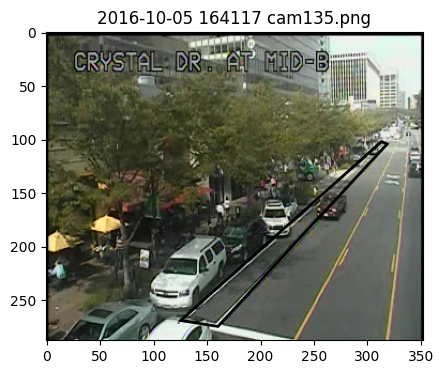

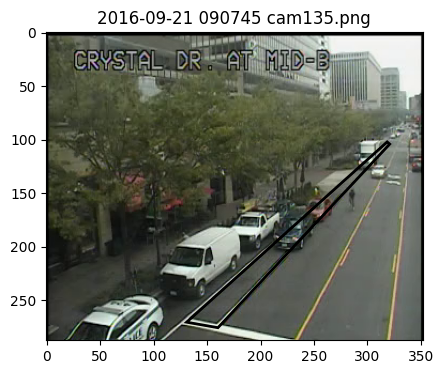

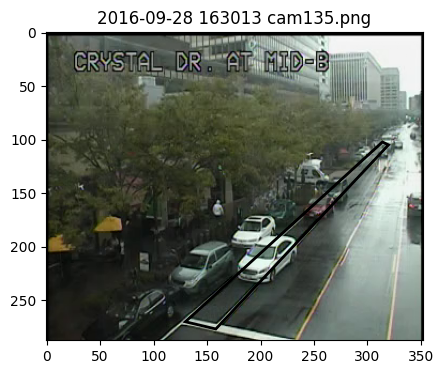

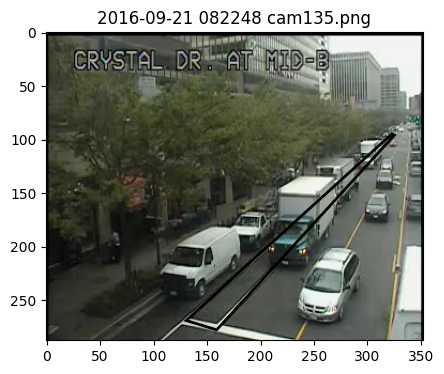

In [15]:
JSON_PATH = "/content/CarInBikeLane/baseline_masks.json"
def load_via_polygons(json_path):
    with open(json_path, "r") as f:
        raw = json.load(f)
    fname_to_polys = {}
    for fname, meta in raw.items():
        regs = meta.get("regions", {})
        polys = []
        for _, r in regs.items():
            sh = r.get("shape_attributes", {})
            if sh.get("name") == "polygon":
                xs = sh.get("all_points_x", [])
                ys = sh.get("all_points_y", [])
                if len(xs) >= 3 and len(xs) == len(ys):
                    polys.append(list(zip(xs, ys)))
        if polys:
            fname_to_polys[fname] = polys
    return fname_to_polys

FNAME_TO_POLYS = load_via_polygons(JSON_PATH)
IMG_GLOB = os.path.join(IMG_ROOT, "**", "*.png")

def preview(n=6):
    shown = 0
    for p in glob.glob(IMG_GLOB, recursive=True):
        fname = os.path.basename(p)
        polys = FNAME_TO_POLYS.get(fname, [])
        if not polys:
            continue
        img = plt.imread(p)
        fig, ax = plt.subplots(figsize=(6,4))
        ax.imshow(img)
        for poly in polys:
            ax.add_patch(Polygon(poly, closed=True, fill=False, linewidth=2))
        ax.set_title(fname)
        plt.show()
        shown += 1
        if shown >= n: break

preview(4)

In [19]:
# makes the polygons from the masks in the json file
# into actual pngs for u-net

TEMPLATE_ROOT = "/content/split_camera_masks"
OUT_ROOT   = "/content/split_camera_lane_masks" # output (one lane mask per image)

os.makedirs(OUT_ROOT, exist_ok=True)

CAM_RE = re.compile(r'cam(\d+)\.png$', re.IGNORECASE)
def cam_id(p):
    m = CAM_RE.search(os.path.basename(p)); return m.group(1) if m else None

# Find one mask per camera
templates = {}  # cam to mask array
for mpath in glob.glob(os.path.join(TEMPLATE_ROOT, "**", "*.png"), recursive=True):
    cam = cam_id(mpath)
    if not cam or cam in templates:
        continue
    m = cv2.imread(mpath, cv2.IMREAD_GRAYSCALE)
    if m is not None and np.count_nonzero(m) > 0:
        templates[cam] = m
print("Found templates for cams:", sorted(templates.keys()))
if not templates:
    raise RuntimeError("No non-empty masks found in TEMPLATE_ROOT. Check TEMPLATE_ROOT path.")

# Apply that template to every image from that camera
written, skipped = 0, 0
for split in ["train","val","test"]:
    for cls in ["blocked","notblocked"]:
        in_dir  = os.path.join(IMG_ROOT, split, cls)
        out_dir = os.path.join(OUT_ROOT, split, cls)
        os.makedirs(out_dir, exist_ok=True)

        for ipath in glob.glob(os.path.join(in_dir, "*.png")):
            cam = cam_id(ipath)
            if cam not in templates:
                skipped += 1
                continue
            img = cv2.imread(ipath)
            if img is None:
                skipped += 1
                continue
            H, W = img.shape[:2]
            tmpl = cv2.resize(templates[cam], (W, H), interpolation=cv2.INTER_NEAREST)
            mask = ((tmpl > 127).astype(np.uint8) * 255)
            Image.fromarray(mask).save(os.path.join(out_dir, os.path.basename(ipath)))
            written += 1

print(f"{written} masks written to {OUT_ROOT}. Skipped {skipped} files.")

Found templates for cams: ['135', '182', '31', '68']
3952 masks written to /content/split_camera_lane_masks. Skipped 0 files.


In [18]:
IMG_SIZE = (256, 256)
BATCH    = 16
SEED = 42

def files_for(split):
    img_paths, msk_paths = [], []
    for cls in ["blocked","notblocked"]:
        for p in glob.glob(os.path.join(IMG_ROOT, split, cls, "*.png")):
            m = os.path.join(MSK_ROOT, split, cls, os.path.basename(p))
            if os.path.exists(m):
                img_paths.append(p)
                msk_paths.append(m)
    return img_paths, msk_paths

train_imgs, train_msks = files_for("train")
val_imgs,   val_msks   = files_for("val")
test_imgs,  test_msks  = files_for("test")

print("counts:",
      "train:", len(train_imgs),
      "val:",   len(val_imgs),
      "test:",  len(test_imgs))

def _load_pair(img_path, msk_path):
    img = tf.io.read_file(img_path); img = tf.image.decode_png(img, 3)
    msk = tf.io.read_file(msk_path);  msk = tf.image.decode_png(msk, 1)
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    msk = tf.image.resize(msk, IMG_SIZE, method="nearest")
    img = tf.cast(img, tf.float32) / 255.0
    msk = tf.cast(msk > 127, tf.float32)
    return img, msk

def _augment(img, msk):
    # keep image+mask in sync
    if tf.random.uniform([]) < 0.5:
        img = tf.image.flip_up_down(img)
        msk = tf.image.flip_up_down(msk)
    img = tf.image.random_brightness(img, 0.10)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, msk

def make_ds(img_paths, msk_paths, train=False):
    # feed two parallel tensors
    ds = tf.data.Dataset.from_tensor_slices(
        (tf.constant(img_paths), tf.constant(msk_paths))
    )
    if train:
        ds = ds.shuffle(len(img_paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(_load_pair, num_parallel_calls=tf.data.AUTOTUNE)
    if train:
        ds = ds.map(_augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_imgs, train_msks, train=True)
val_ds   = make_ds(val_imgs,   val_msks)
test_ds  = make_ds(test_imgs,  test_msks)


counts: train: 2739 val: 1175 test: 38


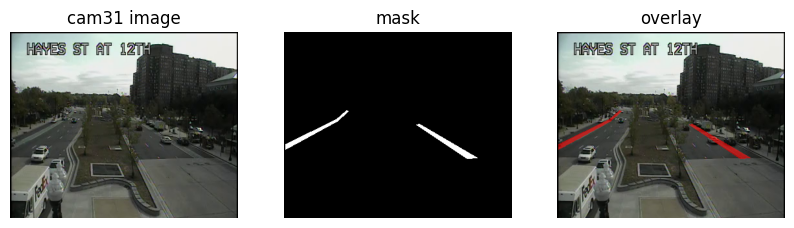

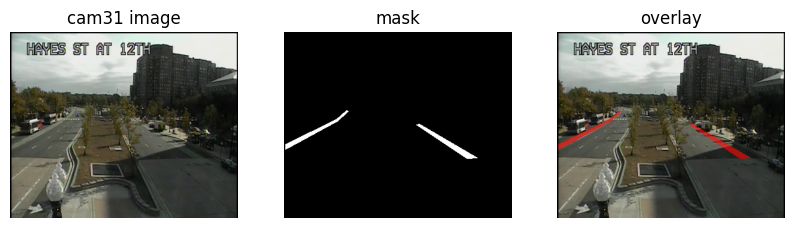

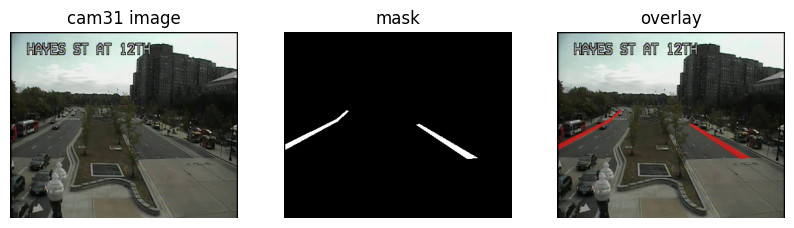

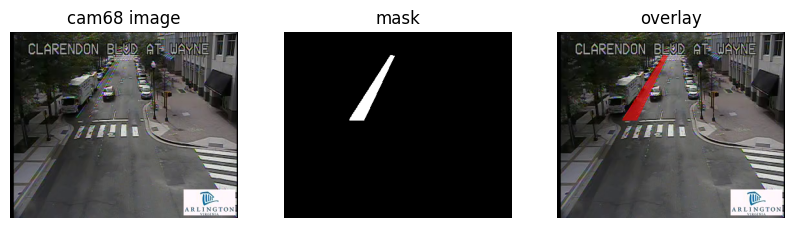

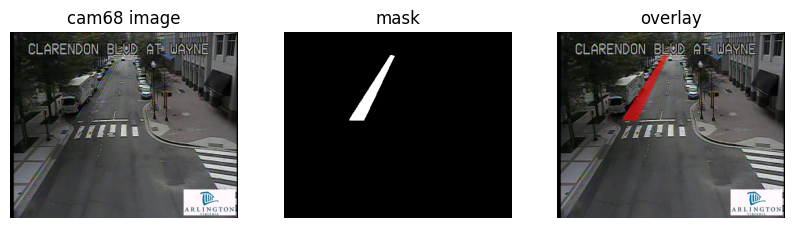

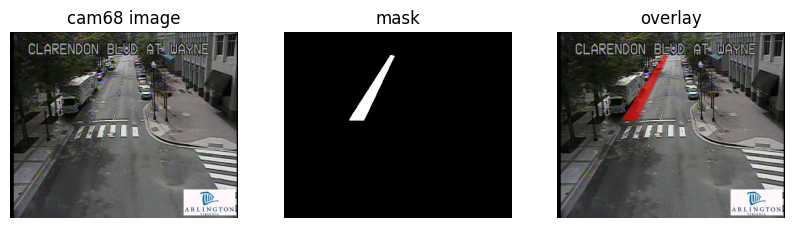

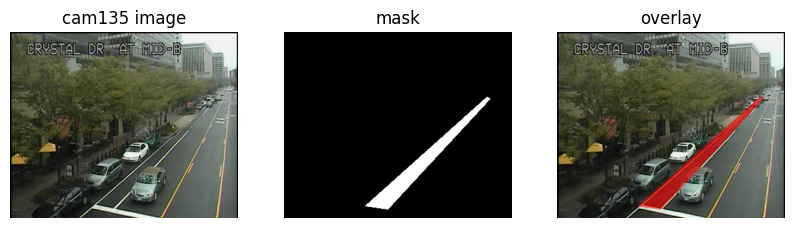

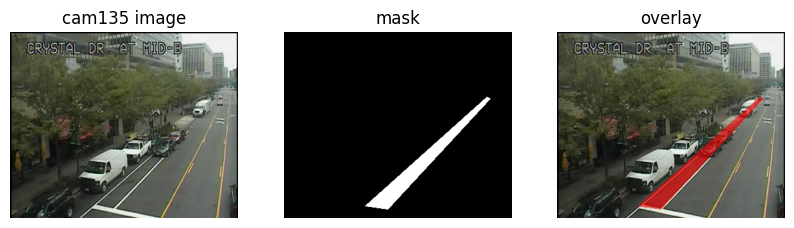

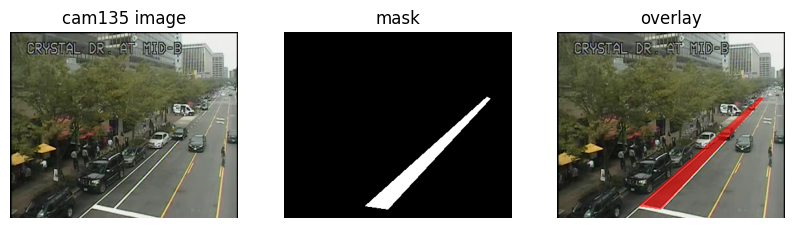

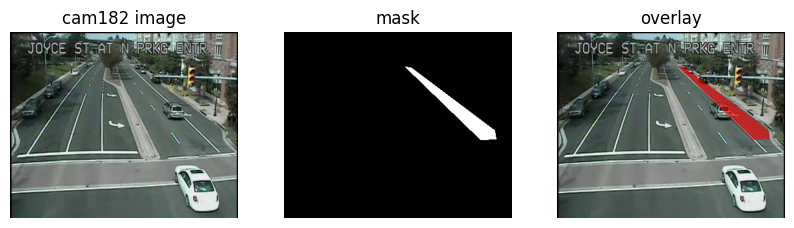

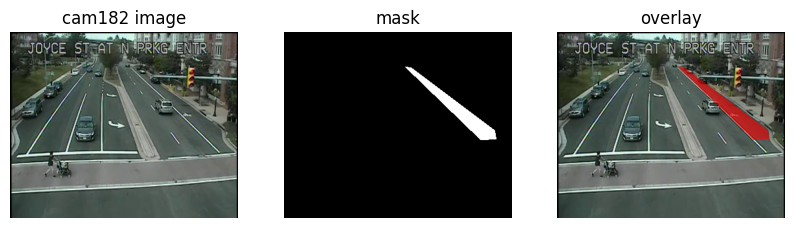

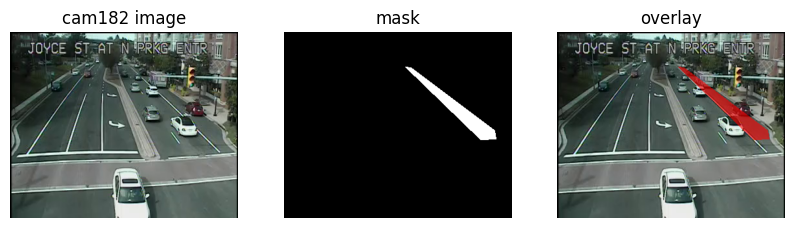

In [20]:
MSK_ROOT = "/content/split_camera_lane_masks"

def show_cam(cam, k=3):
  # gather all paths for this cam across splits/classes
  paths = []
  for split in ["train","val","test"]:
    for cls in ["blocked","notblocked"]:
      cand = glob.glob(os.path.join(IMG_ROOT, split, cls, f"*cam{cam}.png"))
      paths += [(p, split, cls) for p in cand]
  random.shuffle(paths)
  paths = paths[:k]

  for p,split,cls in paths:
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    msk = cv2.imread(os.path.join(MSK_ROOT, split, cls, os.path.basename(p)), 0)
    overlay = img.copy().astype("float32")
    if msk is not None:
      idx = msk > 127
      overlay[idx] = 0.4*overlay[idx] + 0.6*np.array([255,0,0], dtype=np.float32)
    fig, ax = plt.subplots(1,3, figsize=(10,4))
    ax[0].imshow(img); ax[0].set_title(f"cam{cam} image"); ax[0].axis("off")
    ax[1].imshow(msk, cmap="gray"); ax[1].set_title("mask"); ax[1].axis("off")
    ax[2].imshow(overlay.astype("uint8")); ax[2].set_title("overlay"); ax[2].axis("off")
    plt.show()

# run for each camera id
for cam in ["31","68","135","182"]:
  show_cam(cam, k=3)


## YOLOv8 Classification

In [21]:
# Baseline: YOLO boxes for cars intersect lane masks signify blocked

LANE_ROOT = "/content/split_camera_lane_masks"
CONF_THR = 0.25
IOU_THR = 0.5
CAR_CLASSES = {2, 3, 5, 7}  # car, motorcycle, bus, truck COCO IDs

cam_re = re.compile(r'cam(\d+)\.png$', re.IGNORECASE)
def get_cam_id(path):
    m = cam_re.search(os.path.basename(path))
    return m.group(1) if m else "NA"

def iter_images(split_name):
    for cls in ["blocked", "notblocked"]:
        pat = os.path.join(IMG_ROOT, split_name, cls, "*.png")
        for img_path in glob.glob(pat):
            lane_path = os.path.join(LANE_ROOT, split_name, cls, os.path.basename(img_path))
            yield split_name, cls, img_path, lane_path

def overlap_pixels_from_yolo(model, img_path, lane_path):
    img = cv2.imread(img_path)
    if img is None:
        return 0
    H, W = img.shape[:2]
    lane = cv2.imread(lane_path, cv2.IMREAD_GRAYSCALE)
    if lane is None:
        lane = np.zeros((H, W), np.uint8)
    lane = (lane > 127).astype(np.uint8)

    res = model.predict(source=img[..., ::-1], imgsz=640, conf=CONF_THR, iou=IOU_THR, verbose=False)[0]
    car = np.zeros((H, W), np.uint8)
    if res.boxes is not None:
        for b in res.boxes:
            cls_id = int(b.cls.item())
            conf = float(b.conf.item())
            if cls_id in CAR_CLASSES and conf >= CONF_THR:
                x1, y1, x2, y2 = b.xyxy[0].cpu().numpy().astype(int)
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(W - 1, x2), min(H - 1, y2)
                if x2 > x1 and y2 > y1:
                    car[y1:y2 + 1, x1:x2 + 1] = 1
    return int((car & lane).sum())

# Collect overlaps for train/val/test
model = YOLO("yolov8s.pt")
rows = []
for split_name in ["train", "val", "test"]:
    for s, cls, imgp, lanep in iter_images(split_name):
        rows.append({
            "split": s,
            "label": 1 if cls == "blocked" else 0,
            "camera": get_cam_id(imgp),
            "file": os.path.basename(imgp),
            "overlap_px": overlap_pixels_from_yolo(model, imgp, lanep),
        })
df = pd.DataFrame(rows)
print("rows:", len(df))
df.head()

rows: 3952


split  label camera                          file  overlap_px
0  train      1    135  2016-09-22 083022 cam135.png         580
1  train      1    135  2016-09-22 080658 cam135.png         292
2  train      1    135  2016-09-21 114321 cam135.png        2000
3  train      1    135  2016-10-05 183334 cam135.png        1743
4  train      1    135  2016-10-05 142903 cam135.png        1294

In [22]:
# Choose best pixel threshold on VAL, then evaluate on TEST

def eval_on_threshold(th, split_name):
    y = df.loc[df["split"] == split_name, "label"].to_numpy()
    yhat = (df.loc[df["split"] == split_name, "overlap_px"].to_numpy() >= th).astype(int)
    acc = accuracy_score(y, yhat)
    p, r, f1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
    return acc, p, r, f1

cands = np.unique(df.loc[df["split"] == "val", "overlap_px"].to_numpy())
if cands.size == 0:
    cands = np.array([50, 100, 150, 200, 300, 400])

best = None
for th in cands:
    acc, p, r, f1 = eval_on_threshold(th, "val")
    if (best is None) or (acc > best[1]):
        best = (th, acc, p, r, f1)

best_th, v_acc, v_p, v_r, v_f1 = best
print(f"Best VAL threshold = {best_th} px | acc={v_acc:.3f} P={v_p:.3f} R={v_r:.3f} F1={v_f1:.3f}")

t_acc, t_p, t_r, t_f1 = eval_on_threshold(best_th, "test")
print(f"TEST overall | acc={t_acc:.3f} P={t_p:.3f} R={t_r:.3f} F1={t_f1:.3f}")

print("TEST by camera:")
for cam, grp in df[df["split"] == "test"].groupby("camera"):
    y = grp["label"].to_numpy()
    yhat = (grp["overlap_px"].to_numpy() >= best_th).astype(int)
    a = accuracy_score(y, yhat)
    p, r, f1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
    print(f"  cam{cam}: n={len(grp):3d} | acc={a:.3f} P={p:.3f} R={r:.3f} F1={f1:.3f}")

Best VAL threshold = 722 px | acc=0.704 P=0.708 R=0.812 F1=0.757
TEST overall | acc=0.684 P=0.400 R=0.182 F1=0.250
TEST by camera:
  cam68: n= 38 | acc=0.684 P=0.400 R=0.182 F1=0.250


In [24]:

# Grid-search, YOLO confidence + lane dilation

CONF_LIST   = [0.15, 0.25, 0.35]
DILATE_LIST = [0, 3, 5, 7]

model = YOLO("yolov8s.pt")

def iter_images(split):
    for cls in ["blocked","notblocked"]:
        for p in glob.glob(os.path.join(IMG_ROOT, split, cls, "*.png")):
            lane = os.path.join(LANE_ROOT, split, cls, os.path.basename(p))
            label = 1 if cls == "blocked" else 0
            yield split, label, p, lane

# cache YOLO boxes once to speed up the grid-search
records = []

for split in ["train", "val", "test"]:
    for split_name, label, imgp, lanep in iter_images(split):
        img = cv2.imread(imgp)
        if img is None:
            continue

        H, W = img.shape[:2]

        # low threshold for max recall, filtered by grid search at some point
        res = model.predict(
            source=img[..., ::-1],
            imgsz=640,
            conf=0.01,
            iou=0.5,
            verbose=False
        )[0]

        boxes = []
        if res.boxes is not None:
            for b in res.boxes:
                boxes.append((
                    int(b.cls.item()),
                    float(b.conf.item()),
                    *b.xyxy[0].cpu().numpy().astype(int)
                ))

        records.append({
            "split":  split_name,
            "label":  label,
            "img":    imgp,
            "lane":   lanep,
            "H":      H,
            "W":      W,
            "boxes":  boxes,
            "cam":    get_cam_id(imgp),
        })

df = pd.DataFrame(records)
print("cached frames:", len(df))

def overlap_with_params(row, conf_thr, dilate_px):
    lane = cv2.imread(row["lane"], 0)
    if lane is None:
        lane = np.zeros((row["H"], row["W"]), np.uint8)

    lane = (lane > 127).astype(np.uint8)
    if dilate_px > 0:
        k = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE,
            (2*dilate_px + 1, 2*dilate_px + 1)
        )
        lane = cv2.dilate(lane, k)

    car = np.zeros((row["H"], row["W"]), np.uint8)
    for cls_id, conf, x1, y1, x2, y2 in row["boxes"]:
        if cls_id not in CAR_CLASSES or conf < conf_thr:
            continue
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(row["W"] - 1, x2), min(row["H"] - 1, y2)
        if x2 > x1 and y2 > y1:
            car[y1:y2+1, x1:x2+1] = 1

    return int((car & lane).sum())

def eval_split(th, split, overlaps):
    y_true = df.loc[df.split == split, "label"].to_numpy()
    y_pred = (overlaps >= th).astype(int)
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    return acc, p, r, f1

# grid search
best = None

for conf in CONF_LIST:
    for dil in DILATE_LIST:

        # compute overlaps for all rows once
        overlaps = df.apply(
            lambda r: overlap_with_params(r, conf, dil),
            axis=1
        ).to_numpy()

        # VAL subset
        ov_val  = overlaps[df.split.values == "val"]

        # find thresholds
        cands = np.unique(ov_val)
        if cands.size == 0:
            cands = np.array([50, 100, 150, 200, 300, 400])

        # pick VAL F1-optimal threshold
        local_best = None
        for th in cands:
            acc_v, p_v, r_v, f_v = eval_split(th, "val", ov_val)
            if (local_best is None) or (f_v > local_best[0]):
                local_best = (f_v, th, acc_v, p_v, r_v)

        f_val, th_star, a_val, p_val, r_val = local_best

        # evaluate on TEST
        ov_test = overlaps[df.split.values == "test"]
        a_t, p_t, r_t, f_t = eval_split(th_star, "test", ov_test)

        cand = (f_t, a_t, p_t, r_t, conf, dil, th_star, f_val, a_val, p_val, r_val)

        if (best is None) or (cand[0] > best[0]):
            best = cand

(f_t, a_t, p_t, r_t,
 conf_b, dil_b, th_b,
 f_v, a_v, p_v, r_v) = best

print(f"Best params: conf={conf_b}, lane_dilate={dil_b}px, px_thresh={th_b}")
print(f"VAL:  acc={a_v:.3f} P={p_v:.3f} R={r_v:.3f} F1={f_v:.3f}")
print(f"TEST: acc={a_t:.3f} P={p_t:.3f} R={r_t:.3f} F1={f_t:.3f}")

cached frames: 3952
Best params: conf=0.15, lane_dilate=0px, px_thresh=651
VAL:  acc=0.720 P=0.698 R=0.893 F1=0.783
TEST: acc=0.763 P=0.625 R=0.455 F1=0.526


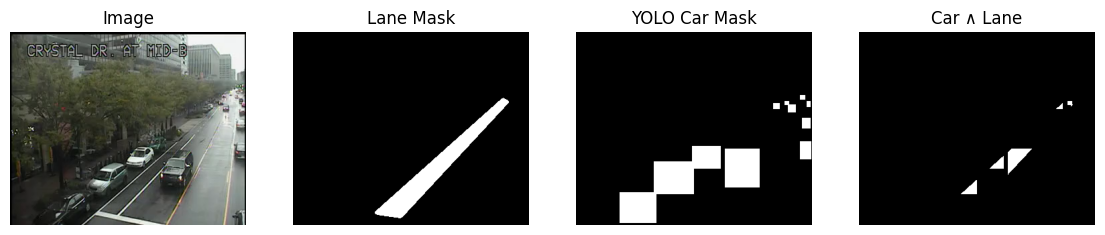

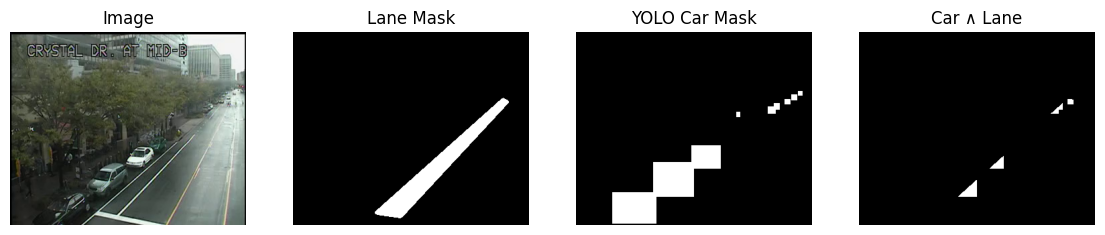

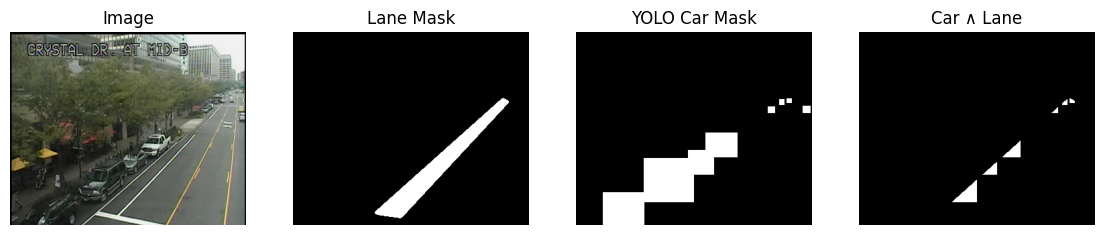

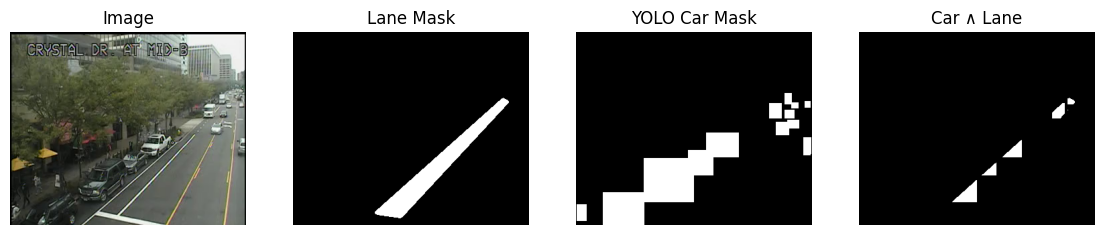

In [25]:
def visualize_car_in_lane(df, n=4, conf=0.15, dilate=3):
    import random
    rows = df.sample(n)

    for idx, row in rows.iterrows():
        # load img
        img = cv2.cvtColor(cv2.imread(row["img"]), cv2.COLOR_BGR2RGB)

        # load lane mask
        lane = cv2.imread(row["lane"], 0)
        if lane is None:
            lane = np.zeros((row["H"], row["W"]), np.uint8)
        lane = (lane > 127).astype(np.uint8)

        # lane dilation
        if dilate > 0:
            k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*dilate+1, 2*dilate+1))
            lane = cv2.dilate(lane, k)

        # build car mask
        car = np.zeros((row["H"], row["W"]), np.uint8)
        for cls_id, c, x1,y1,x2,y2 in row["boxes"]:
            if cls_id in CAR_CLASSES and c >= conf:
                car[y1:y2+1, x1:x2+1] = 255

        car_in_lane = cv2.bitwise_and(car, lane)

        # show 4-panel visualization
        fig, ax = plt.subplots(1,4, figsize=(14,4))
        ax[0].imshow(img); ax[0].set_title("Image"); ax[0].axis("off")
        ax[1].imshow(lane, cmap='gray'); ax[1].set_title("Lane Mask"); ax[1].axis("off")
        ax[2].imshow(car, cmap='gray'); ax[2].set_title("YOLO Car Mask"); ax[2].axis("off")
        ax[3].imshow(car_in_lane, cmap='gray'); ax[3].set_title("Car ∧ Lane"); ax[3].axis("off")
        plt.show()

# run visualization
visualize_car_in_lane(df, n=4)

## U-NET

In [28]:
IMG_SIZE = (256,256)
BATCH=16

def list_pairs(split):
    pairs=[]
    for cls in ["blocked","notblocked"]:
        for p in glob.glob(os.path.join(IMG_ROOT, split, cls, "*.png")):
            m = os.path.join(MSK_ROOT, split, cls, os.path.basename(p))
            if os.path.exists(m):
                pairs.append((p,m))
    return pairs

def split_pos_neg(pairs):
    pos,neg=[],[]
    for p,m in pairs:
        mm=cv2.imread(m,0)
        (pos if mm is not None and np.count_nonzero(mm)>0 else neg).append((p,m))
    return pos,neg

train_pairs = list_pairs("train")
val_pairs   = list_pairs("val")
test_pairs  = list_pairs("test")

pos_pairs, neg_pairs = split_pos_neg(train_pairs)

def _load_pair(i,m):
    i=tf.io.read_file(i); i=tf.image.decode_png(i,3)
    m=tf.io.read_file(m); m=tf.image.decode_png(m,1)
    i=tf.image.resize(i,IMG_SIZE,antialias=True)/255.0
    m=tf.image.resize(m,IMG_SIZE,method="nearest")
    m=tf.cast(m>127,tf.float32)
    return i,m

def _aug(i,m):
    if tf.random.uniform([])<0.5:
        i=tf.image.flip_up_down(i)
        m=tf.image.flip_up_down(m)
    i=tf.image.random_brightness(i,0.1)
    i=tf.image.random_contrast(i,0.9,1.1)
    return i,m

def simple_ds(pairs, aug=False):
    i=tf.constant([p for p,_ in pairs])
    m=tf.constant([m for _,m in pairs])
    ds=tf.data.Dataset.from_tensor_slices((i,m))
    if aug:
        ds=ds.shuffle(len(pairs), seed=SEED)
    ds=ds.map(_load_pair, num_parallel_calls=tf.data.AUTOTUNE)
    if aug:
        ds=ds.map(_aug, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

train_ds = simple_ds(train_pairs, aug=True)
val_ds   = simple_ds(val_pairs)
test_ds  = simple_ds(test_pairs)

steps = max(100, (len(train_pairs)//BATCH))

# U-NET

def conv_blk(x,f):
    x=L.Conv2D(f,3,padding="same")(x);
    x=L.BatchNormalization()(x);
    x=L.ReLU()(x)
    x=L.Conv2D(f,3,padding="same")(x);
    x=L.BatchNormalization()(x);
    x=L.ReLU()(x)
    return x

def unet(in_shape=(256,256,3), base=32):
    i=L.Input(in_shape)
    c1=conv_blk(i,base);     p1=L.MaxPool2D()(c1)
    c2=conv_blk(p1,base*2);  p2=L.MaxPool2D()(c2)
    c3=conv_blk(p2,base*4);  p3=L.MaxPool2D()(c3)
    c4=conv_blk(p3,base*8);  p4=L.MaxPool2D()(c4)
    bn=conv_blk(p4,base*16)

    u4=L.Conv2DTranspose(base*8,2,2,"same")(bn)
    u4=L.Concatenate()([u4,c4]); c5=conv_blk(u4,base*8)

    u3=L.Conv2DTranspose(base*4,2,2,"same")(c5)
    u3=L.Concatenate()([u3,c3]); c6=conv_blk(u3,base*4)

    u2=L.Conv2DTranspose(base*2,2,2,"same")(c6)
    u2=L.Concatenate()([u2,c2]); c7=conv_blk(u2,base*2)

    u1=L.Conv2DTranspose(base,2,2,"same")(c7)
    u1=L.Concatenate()([u1,c1]); c8=conv_blk(u1,base)

    o=L.Conv2D(1,1,activation="sigmoid")(c8)
    return Model(i,o)

def dice_coef(y_true,y_pred,eps=1e-6):
    y_true=tf.reshape(y_true,[-1])
    y_pred=tf.reshape(y_pred,[-1])
    inter=tf.reduce_sum(y_true*y_pred)
    return (2*inter+eps)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+eps)

def dice_loss(y_true,y_pred):
    return 1.0 - dice_coef(y_true,y_pred)

model = unet(in_shape=(*IMG_SIZE,3), base=32)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=lambda yt,yp: 0.5*tf.keras.losses.binary_crossentropy(yt,yp) + 0.5*dice_loss(yt,yp),
    metrics=[dice_coef]
)

ckpt = tf.keras.callbacks.ModelCheckpoint(
    "/content/best_unet.keras",
    monitor="val_dice_coef", mode="max", save_best_only=True
)
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_dice_coef", mode="max", patience=6, restore_best_weights=True
)

model.fit(
    train_ds,
    steps_per_epoch=steps,
    validation_data=val_ds,
    epochs=30,
    callbacks=[ckpt, es]
)

Epoch 1/30
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - dice_coef: 0.2861 - loss: 0.5194

/usr/local/lib/python3.12/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda yt,yp: 0.5*tf.keras.losses.binary_crossentropy(yt,yp) + 0.5*dice_loss(yt,yp),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


171/171 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step - dice_coef: 0.2877 - loss: 0.5177 - val_dice_coef: 0.0492 - val_loss: 0.5658
Epoch 2/30
  1/171 ━━━━━━━━━━━━━━━━━━━━ 39:11 14s/step - dice_coef: 0.7147 - loss: 0.1601

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - dice_coef: 0.7147 - loss: 0.1601 - val_dice_coef: 0.0488 - val_loss: 0.5658
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - dice_coef: 0.7849 - loss: 0.1211 - val_dice_coef: 0.5943 - val_loss: 0.2539
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dice_coef: 0.8736 - loss: 0.0777 - val_dice_coef: 0.5279 - val_loss: 0.2946
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - dice_coef: 0.9376 - loss: 0.0352 - val_dice_coef: 0.9429 - val_loss: 0.0335
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dice_coef: 0.9728 - loss: 0.0149 - val_dice_coef: 0.9420 - val_loss: 0.0341
Epoch 7/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - dice_coef: 0.9758 - loss: 0.0137 - val_dice_coef: 0.9150 - val_loss: 0.0537
Epoch 8/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dice_coef: 0.9857 - loss: 0.0078 - val_dice_coef: 0.8555 - val_loss: 0.0945
Epoch 9/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - dice_coef: 0.9829 - loss: 0.0100 - val

In [29]:
model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - dice_coef: 1.6853e-04 - loss: 0.5765


[0.5763583183288574, 0.00017406562983524054]

## Visualize Best YOLO

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


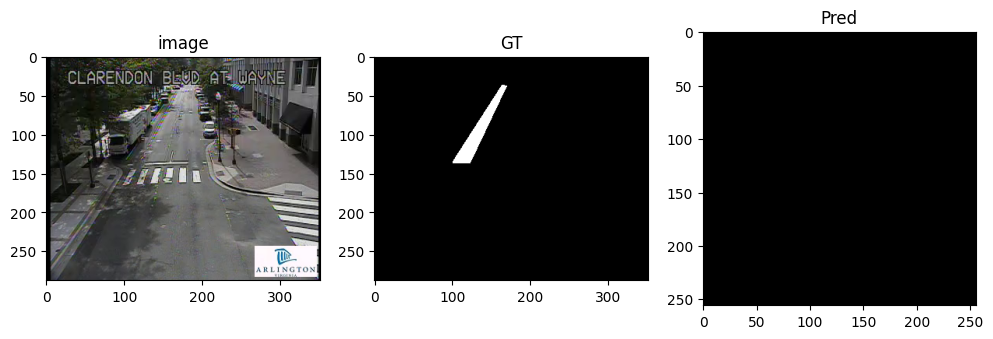

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


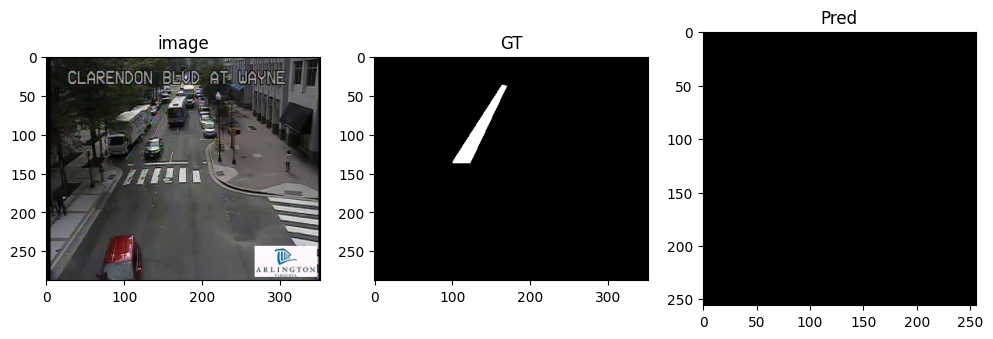

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


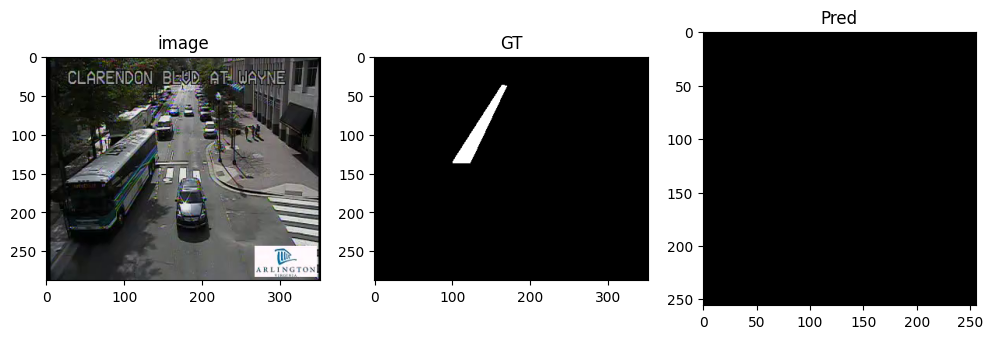

In [31]:
for i,(img_path, msk_path) in enumerate(test_pairs[:3]):
    img = cv2.imread(img_path)[...,::-1]
    mm  = cv2.imread(msk_path,0)

    pred = model.predict(np.expand_dims(cv2.resize(img/255.0, IMG_SIZE),0))[0]
    pred = (pred[...,0] > 0.5).astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("image")
    plt.subplot(1,3,2); plt.imshow(mm,cmap='gray'); plt.title("GT")
    plt.subplot(1,3,3); plt.imshow(pred,cmap='gray'); plt.title("Pred")
    plt.show()

Top False Positives n= 3


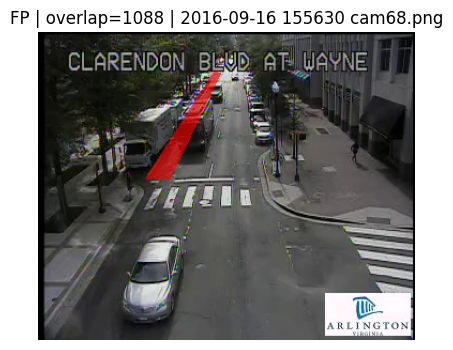

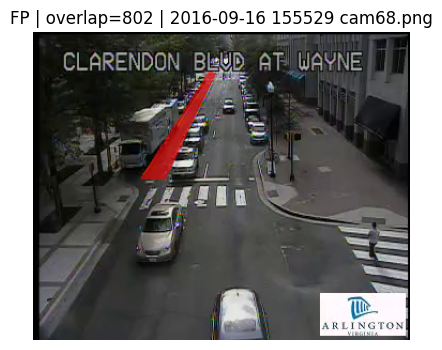

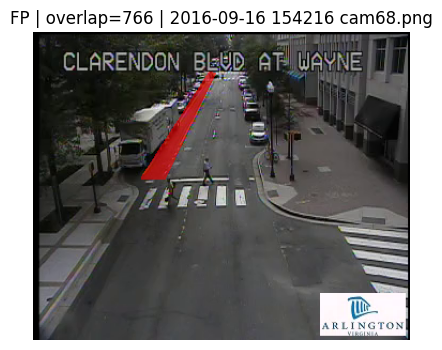

Top False Negatives n= 6


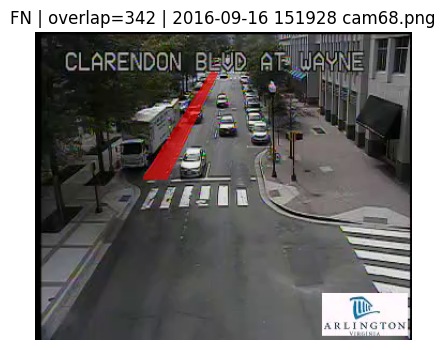

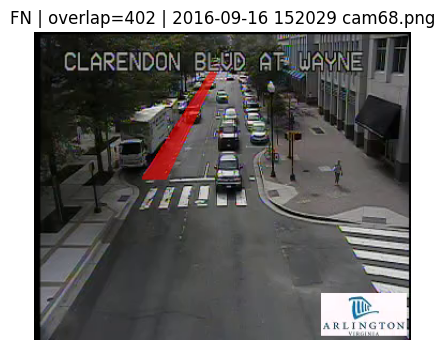

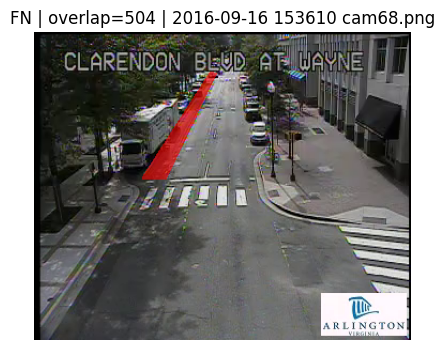

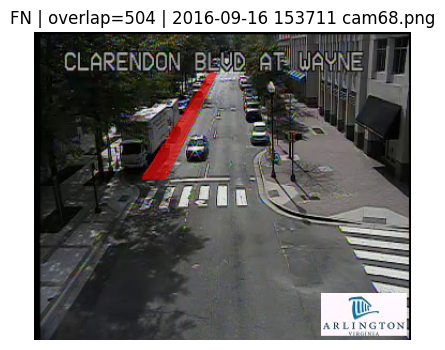

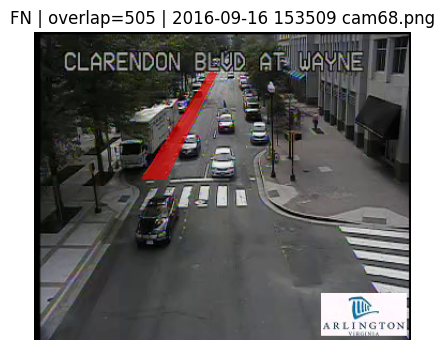

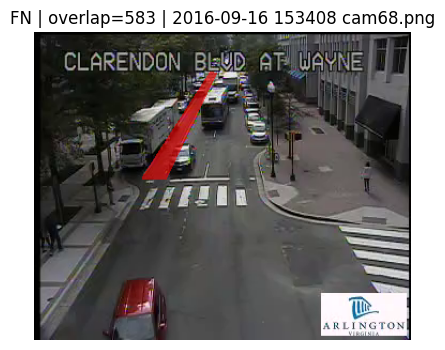

In [32]:
# compute best-overlaps once
overlaps_best = df.apply(
    lambda r: overlap_with_params(r, conf_b, dil_b),
    axis=1
).to_numpy()

df["overlap_best"] = overlaps_best

test_rows = df[df.split == "test"].copy()

y_true = test_rows["label"].to_numpy()
y_pred = (test_rows["overlap_best"].to_numpy() >= th_b).astype(int)

test_rows["pred"] = y_pred

# use overlap as score
test_rows["score"] = test_rows["overlap_best"]
test_rows["file"]  = test_rows["img"].apply(os.path.basename)

k = 6

FP = test_rows[(test_rows.label == 0) & (test_rows.pred == 1)] \
        .sort_values("score", ascending=False).head(k)

FN = test_rows[(test_rows.label == 1) & (test_rows.pred == 0)] \
        .sort_values("score", ascending=True).head(k)

def show_rows(rows, title):
    print(title, "n=", len(rows))
    for _, r in rows.iterrows():
        cls  = "blocked" if int(r.label)==1 else "notblocked"
        imgp = os.path.join(IMG_ROOT, "test", cls, r["file"])
        mskp = os.path.join(MSK_ROOT,"test", cls, r["file"])

        img = cv2.cvtColor(cv2.imread(imgp), cv2.COLOR_BGR2RGB)
        lane = cv2.imread(mskp, 0)

        ov = img.copy().astype(np.float32)
        if lane is not None:
            idx = lane > 127
            ov[idx] = 0.4*ov[idx] + 0.6*np.array([255, 0, 0], np.float32)

        plt.figure(figsize=(5,4))
        plt.imshow(ov.astype(np.uint8))
        plt.axis("off")

        tag = "FP" if int(r.label)==0 else "FN"
        plt.title(f"{tag} | overlap={int(r.score)} | {r['file']}")
        plt.show()

show_rows(FP, "Top False Positives")
show_rows(FN, "Top False Negatives")

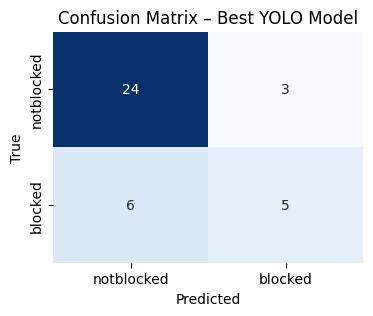

In [33]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["notblocked","blocked"],
            yticklabels=["notblocked","blocked"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Best YOLO Model")
plt.show()